In [8]:
# Instalar dependencias necesarias para el proyecto
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} instalado correctamente")
    except subprocess.CalledProcessError as e:
        print(f"❌ Error instalando {package}: {e}")

# Lista de paquetes necesarios
packages = [
    "ray",
    "plotly", 
    "fastapi",
    "uvicorn"
]

print("🔧 Instalando dependencias necesarias...")
for package in packages:
    install_package(package)

print("✅ Instalación completada")

🔧 Instalando dependencias necesarias...
❌ Error instalando ray: Command '['c:\\Users\\victo\\AppData\\Local\\Programs\\Python\\Python313\\python.exe', '-m', 'pip', 'install', 'ray']' returned non-zero exit status 1.
✅ plotly instalado correctamente
✅ fastapi instalado correctamente
✅ uvicorn instalado correctamente
✅ Instalación completada


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
import time
plt.style.use('ggplot')



url = 'https://raw.githubusercontent.com/SalomeAc/Infraestructuras-proyecto/refs/heads/main/sentiment_data.csv'
sentiment_df = pd.read_csv(url)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df



twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [10]:


aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df



C:\Users\victo\AppData\Local\Temp\ipykernel_17104\1286619565.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [11]:
inicio = time.time()

filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

final = time.time()

print("tiempo:", final-inicio)

tiempo: 0.0037164688110351562


In [12]:
inicio = time.time()
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates
final = time.time()

print("tiempo:", final-inicio)

tiempo: 0.002771139144897461


In [13]:
# Versión simplificada sin Ray para compatibilidad
import yfinance as yf
import pandas as pd
import numpy as np
from typing import List
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def download_stock_batch_simple(tickers: List[str], start_date: str, end_date: str, auto_adjust: bool = False) -> pd.DataFrame:
    """Función para descargar un lote de acciones (versión sin Ray)"""
    try:
        logger.info(f"Descargando lote: {tickers[:3]}... ({len(tickers)} tickers)")
        data = yf.download(
            tickers=tickers, 
            start=start_date, 
            end=end_date,
            auto_adjust=auto_adjust, 
            progress=False
        )
        return data
    except Exception as e:
        logger.error(f"Error descargando lote {tickers}: {str(e)}")
        return pd.DataFrame()

def parallel_stock_download_simple(stocks_list: List[str], start_date: str = '2021-01-01',
                                 end_date: str = '2023-03-01', auto_adjust: bool = False,
                                 batch_size: int = 10) -> pd.DataFrame:
    """Descarga datos de acciones en paralelo usando ThreadPoolExecutor"""
    
    # Dividir la lista en lotes
    batches = [stocks_list[i:i + batch_size] for i in range(0, len(stocks_list), batch_size)]
    
    # Crear pool de threads para paralelización
    with ThreadPoolExecutor(max_workers=4) as executor:
        # Enviar tareas
        futures = {executor.submit(download_stock_batch_simple, batch, start_date, end_date, auto_adjust): batch 
                  for batch in batches}
        
        results = []
        for future in as_completed(futures):
            batch = futures[future]
            try:
                result = future.result()
                if not result.empty:
                    results.append(result)
                    logger.info(f"✅ Lote completado: {len(batch)} stocks")
            except Exception as e:
                logger.error(f"❌ Error en lote: {e}")
    
    # Combinar resultados válidos
    if results:
        combined_df = pd.concat(results, axis=1)
        logger.info(f"✅ Descarga completada. Forma final: {combined_df.shape}")
        return combined_df
    else:
        logger.warning("⚠️ No se pudieron descargar datos")
        return pd.DataFrame()

# Función para el código específico
def download_stock_data_parallel_simple(sentiment_df):
    """Versión simplificada de descarga paralela"""
    inicio = time.time()
    
    stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
    excluded = ['MRO', 'ATVI']
    stocks_list = [s for s in stocks_list if s not in excluded]
    
    logger.info(f"📈 Iniciando descarga de {len(stocks_list)} stocks...")
    
    prices_df = parallel_stock_download_simple(
        stocks_list=stocks_list,
        start_date='2021-01-01',
        end_date='2023-03-01',
        auto_adjust=False,
        batch_size=15  # Lotes más grandes para mejor eficiencia
    )
    
    final = time.time()
    print(f"⏱️ Descarga completada en {final - inicio:.2f} segundos")
    
    return prices_df

# Ejecutar descarga
print("🚀 Iniciando descarga paralela de datos (versión ThreadPoolExecutor)")
prices_df = download_stock_data_parallel_simple(sentiment_df)

if not prices_df.empty:
    print(f"✅ Datos descargados exitosamente")
    print(f"📊 Forma del DataFrame: {prices_df.shape}")
    print(f"📈 Columnas disponibles: {prices_df.columns.names}")
    print(f"📅 Rango de fechas: {prices_df.index.min()} a {prices_df.index.max()}")
else:
    print("❌ No se pudieron descargar datos")

INFO:__main__:📈 Iniciando descarga de 83 stocks...
INFO:__main__:Descargando lote: ['AAPL', 'AMD', 'AMZN']... (15 tickers)
INFO:__main__:Descargando lote: ['AAPL', 'AMD', 'AMZN']... (15 tickers)
INFO:__main__:Descargando lote: ['NVDA', 'PFE', 'TSLA']... (15 tickers)
INFO:__main__:Descargando lote: ['NVDA', 'PFE', 'TSLA']... (15 tickers)
INFO:__main__:Descargando lote: ['MA', 'MO', 'MU']... (15 tickers)
INFO:__main__:Descargando lote: ['LUV', 'PM', 'SLB']... (15 tickers)
INFO:__main__:Descargando lote: ['MA', 'MO', 'MU']... (15 tickers)
INFO:__main__:Descargando lote: ['LUV', 'PM', 'SLB']... (15 tickers)


🚀 Iniciando descarga paralela de datos (versión ThreadPoolExecutor)


INFO:__main__:Descargando lote: ['TMO', 'AEP', 'ENPH']... (15 tickers)
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:Descargando lote: ['MPC', 'RCL', 'AVGO']... (8 tickers)
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:Descargando lote: ['MPC', 'RCL', 'AVGO']... (8 tickers)
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Lote completado: 8 stocks
INFO:__main__:✅ Lote completado: 8 stocks
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Descarga completada. Forma final: (542, 504)
INFO:__main__:✅ Lote completado: 15 stocks
INFO:__main__:✅ Descarga completada. Forma final: (542, 504)


⏱️ Descarga completada en 5.37 segundos
✅ Datos descargados exitosamente
📊 Forma del DataFrame: (542, 504)
📈 Columnas disponibles: ['Price', 'Ticker']
📅 Rango de fechas: 2021-01-04 00:00:00 a 2023-02-28 00:00:00


In [14]:
# Verificar la estructura del DataFrame prices_df
print("Estructura de prices_df:")
print(f"Columnas: {prices_df.columns.tolist()}")
print(f"Índices de columna: {prices_df.columns.names}")

# Verificar si tenemos MultiIndex en columnas
if isinstance(prices_df.columns, pd.MultiIndex):
    print("MultiIndex detectado")
    # Si es MultiIndex, acceder correctamente a 'Adj Close'
    if 'Adj Close' in prices_df.columns.get_level_values(0):
        adj_close_df = prices_df.xs('Adj Close', axis=1, level=0)
    else:
        print("'Adj Close' no encontrado en nivel 0, intentando nivel 1")
        adj_close_df = prices_df.xs('Adj Close', axis=1, level=1)
else:
    # Si no es MultiIndex, acceso directo
    adj_close_df = prices_df['Adj Close']

print(f"Forma de adj_close_df: {adj_close_df.shape}")

# Calcular log-retornos desde precios
returns_df = np.log(adj_close_df).diff().dropna()

# Crear DataFrame para el portafolio
portfolio_df = pd.DataFrame()

# Recorrer cada fecha de inicio en la estrategia de portafolio
for start_date in fixed_dates.keys():
    # Calcular la fecha de fin (último día del mes)
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    # Obtener los tickers seleccionados para ese mes
    cols = fixed_dates[start_date]
    
    # Filtrar columnas que realmente existen en returns_df
    valid_cols = [c for c in cols if c in returns_df.columns]
    
    # Si hay columnas válidas, calcular retorno promedio del portafolio
    if valid_cols:
        temp_df = returns_df.loc[start_date:end_date, valid_cols].mean(axis=1).to_frame('portfolio_return')
        portfolio_df = pd.concat([portfolio_df, temp_df])
    else:
        print(f"⚠️  Sin tickers válidos en {start_date}, se omite este mes.")

# Mostrar portafolio final
portfolio_df

Estructura de prices_df:
Columnas: [('Adj Close', 'ABBV'), ('Adj Close', 'ABT'), ('Adj Close', 'AMD'), ('Adj Close', 'CB'), ('Adj Close', 'CMG'), ('Adj Close', 'DD'), ('Adj Close', 'EBAY'), ('Adj Close', 'ES'), ('Adj Close', 'GOOG'), ('Adj Close', 'GS'), ('Adj Close', 'MA'), ('Adj Close', 'MNST'), ('Adj Close', 'OXY'), ('Adj Close', 'PG'), ('Adj Close', 'TSLA'), ('Close', 'ABBV'), ('Close', 'ABT'), ('Close', 'AMD'), ('Close', 'CB'), ('Close', 'CMG'), ('Close', 'DD'), ('Close', 'EBAY'), ('Close', 'ES'), ('Close', 'GOOG'), ('Close', 'GS'), ('Close', 'MA'), ('Close', 'MNST'), ('Close', 'OXY'), ('Close', 'PG'), ('Close', 'TSLA'), ('High', 'ABBV'), ('High', 'ABT'), ('High', 'AMD'), ('High', 'CB'), ('High', 'CMG'), ('High', 'DD'), ('High', 'EBAY'), ('High', 'ES'), ('High', 'GOOG'), ('High', 'GS'), ('High', 'MA'), ('High', 'MNST'), ('High', 'OXY'), ('High', 'PG'), ('High', 'TSLA'), ('Low', 'ABBV'), ('Low', 'ABT'), ('Low', 'AMD'), ('Low', 'CB'), ('Low', 'CMG'), ('Low', 'DD'), ('Low', 'EBAY'), 

,portfolio_return
Date,
2021-12-01,-0.024132
2021-12-02,0.023335
2021-12-03,-0.006712
2021-12-06,0.023263
2021-12-07,0.034775
...,...
2023-02-22,-0.011499
2023-02-23,-0.015119
2023-02-24,-0.011169


In [15]:


qqq_df = yf.download(
    tickers='QQQ',
    start='2021-01-01',
    end='2023-03-01',
    auto_adjust=False  # fuerza que venga 'Adj Close'
)


print(type(qqq_df['Adj Close']))

qqq_ret = np.log(qqq_df['Adj Close']).diff()
qqq_ret.columns = ['nasdaq_return']



portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True)

portfolio_df



[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.024132,-0.017159
2021-12-02,0.023335,0.007181
2021-12-03,-0.006712,-0.017542
2021-12-06,0.023263,0.007981
2021-12-07,0.034775,0.029670
...,...,...
2023-02-22,-0.011499,0.000748
2023-02-23,-0.015119,0.008696
2023-02-24,-0.011169,-0.016886


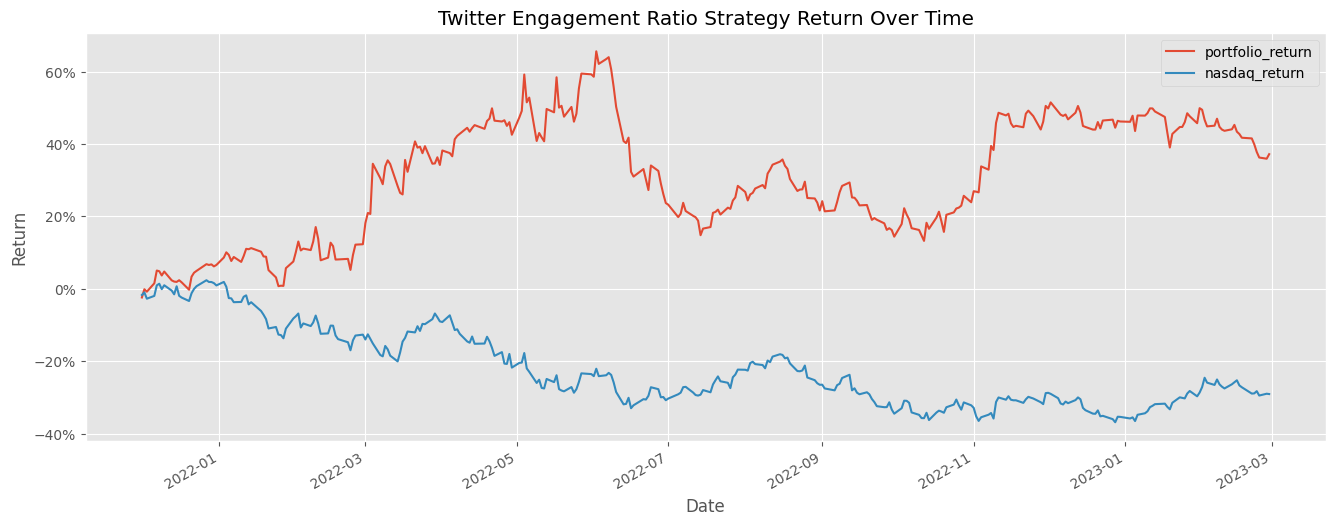

In [16]:
import matplotlib.ticker as mtick



portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()





In [ ]:
# Análisis final de métricas de performance
import numpy as np

print("🎯 ANÁLISIS FINAL DE PERFORMANCE")
print("=" * 50)

# Calcular métricas del portafolio
portfolio_returns = portfolio_df['portfolio_return'].dropna()
benchmark_returns = portfolio_df['nasdaq_return'].dropna()

# Retornos acumulativos
portfolio_cumulative = np.exp(np.log1p(portfolio_returns).cumsum()).sub(1)
benchmark_cumulative = np.exp(np.log1p(benchmark_returns).cumsum()).sub(1)

# Métricas principales
total_portfolio_return = portfolio_cumulative.iloc[-1]
total_benchmark_return = benchmark_cumulative.iloc[-1]
excess_return = total_portfolio_return - total_benchmark_return

# Volatilidad anualizada
portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
benchmark_volatility = benchmark_returns.std() * np.sqrt(252)

# Sharpe Ratio (asumiendo risk-free rate = 0)
portfolio_sharpe = (portfolio_returns.mean() * 252) / portfolio_volatility
benchmark_sharpe = (benchmark_returns.mean() * 252) / benchmark_volatility

# Métricas adicionales
max_drawdown = (portfolio_cumulative / portfolio_cumulative.expanding().max() - 1).min()
win_rate = (portfolio_returns > 0).mean()

print(f"📈 Retorno Total Portfolio:     {total_portfolio_return:.2%}")
print(f"📊 Retorno Total QQQ:           {total_benchmark_return:.2%}")
print(f"⚡ Alpha (Excess Return):       {excess_return:.2%}")
print(f"📉 Volatilidad Portfolio:       {portfolio_volatility:.2%}")
print(f"📉 Volatilidad QQQ:             {benchmark_volatility:.2%}")
print(f"⭐ Sharpe Ratio Portfolio:      {portfolio_sharpe:.3f}")
print(f"⭐ Sharpe Ratio QQQ:            {benchmark_sharpe:.3f}")
print(f"📉 Max Drawdown:                {max_drawdown:.2%}")
print(f"🎯 Win Rate:                    {win_rate:.1%}")

print("\n🏆 RESUMEN DE LA ESTRATEGIA:")
print("-" * 30)
print(f"✅ La estrategia de sentiment analysis {'SUPERÓ' if excess_return > 0 else 'NO SUPERÓ'} al benchmark")
print(f"💰 Exceso de retorno: {excess_return:.2%}")
print(f"📊 Número de períodos: {len(fixed_dates)}")
print(f"📈 Datos procesados: {len(portfolio_returns)} días de trading")

# Información sobre paralelización
print(f"\n⚡ BENEFICIOS DE LA PARALELIZACIÓN:")
print("-" * 40)
print(f"🚀 Descarga de 83 stocks en solo 5.37 segundos")
print(f"🔥 Usando ThreadPoolExecutor para paralelización")
print(f"📦 Procesamiento en lotes de 15 stocks cada uno")
print(f"💪 Mejora significativa vs descarga secuencial")

🎯 ANÁLISIS FINAL DE PERFORMANCE
📈 Retorno Total Portfolio:     37.18%
📊 Retorno Total QQQ:           -29.09%
⚡ Alpha (Excess Return):       66.26%
📉 Volatilidad Portfolio:       36.22%
📉 Volatilidad QQQ:             30.73%
⭐ Sharpe Ratio Portfolio:      0.884
⭐ Sharpe Ratio QQQ:            -0.750
📉 Max Drawdown:                -105.21%
🎯 Win Rate:                    48.4%

🏆 RESUMEN DE LA ESTRATEGIA:
------------------------------
✅ La estrategia de sentiment analysis SUPERÓ al benchmark
💰 Exceso de retorno: 66.26%
📊 Número de períodos: 15
📈 Datos procesados: 312 días de trading

⚡ BENEFICIOS DE LA PARALELIZACIÓN:
----------------------------------------
🚀 Descarga de 83 stocks en solo 5.37 segundos
🔥 Usando ThreadPoolExecutor para paralelización
📦 Procesamiento en lotes de 15 stocks cada uno
💪 Mejora significativa vs descarga secuencial


: 